In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import (Input, Add, Dense, Activation,
ZeroPadding2D, BatchNormalization, Flatten, Conv2D,
AveragePooling2D, MaxPooling2D, Dropout)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (ReduceLROnPlateau,
EarlyStopping, ModelCheckpoint, LearningRateScheduler)
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [54]:
sales_df = pd.read_csv('DataSet/sales_data_sample.csv', sep=',', decimal='.', encoding = "ISO-8859-1")
sales_df.groupby('COUNTRY').size()
sales_df = sales_df.drop(['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY',
'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME',
'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER', 'STATUS', 'ORDERDATE', 'QTR_ID'], axis=1)

def dummies(x):
    dummy = pd.get_dummies(sales_df[x])
    sales_df.drop(columns = x , inplace = True)
    return pd.concat([sales_df, dummy], axis = 1)

sales_df = dummies("COUNTRY")
sales_df = dummies("PRODUCTLINE")
sales_df = dummies("DEALSIZE")
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [42]:
from keras.optimizers import SGD

In [46]:
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

In [47]:
autoencoder = Model(input_df, decoded)

In [48]:
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [55]:
autoencoder.fit(sales_df_scaled, sales_df_scaled, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [58]:
autoencoder.save_weights('autoencoder_1.h5')
pred = encoder.predict(sales_df_scaled)
pred

89/89 [==============================] - 0s 5ms/step


array([[ 1.0496207 ,  0.66961646,  0.7148004 , ...,  1.8465837 ,
         0.9283152 ,  1.3384658 ],
       [ 0.31137693,  5.8757505 ,  3.209888  , ...,  5.339368  ,
         4.555996  ,  1.5729927 ],
       [ 0.37770623,  6.3168135 ,  3.441737  , ...,  5.8080077 ,
         5.8011084 ,  3.6923227 ],
       ...,
       [ 5.7687325 ,  2.884734  , 12.861768  , ...,  4.555678  ,
         3.9496841 ,  7.077875  ],
       [ 3.5616498 ,  5.7377768 , 10.532413  , ...,  6.111966  ,
         3.0840483 ,  2.658945  ],
       [ 5.523043  ,  3.8379421 ,  8.490349  , ...,  2.8285897 ,
         1.9601951 ,  4.395155  ]], dtype=float32)

In [ ]:
scores = []
range_values = range(1, 15)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    scores.append(kmeans.inertia_)
plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clústers')
plt.xlabel('No de Clústers')
plt.ylabel('WCSS')
plt.show()

In [60]:
kmeans = KMeans(4)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [89]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUANTITYORDERED   2823 non-null   int64  
 1   PRICEEACH         2823 non-null   float64
 2   ORDERLINENUMBER   2823 non-null   int64  
 3   SALES             2823 non-null   float64
 4   MONTH_ID          2823 non-null   int64  
 5   YEAR_ID           2823 non-null   int64  
 6   MSRP              2823 non-null   int64  
 7   PRODUCTCODE       2823 non-null   int8   
 8   Australia         2823 non-null   uint8  
 9   Austria           2823 non-null   uint8  
 10  Belgium           2823 non-null   uint8  
 11  Canada            2823 non-null   uint8  
 12  Denmark           2823 non-null   uint8  
 13  Finland           2823 non-null   uint8  
 14  France            2823 non-null   uint8  
 15  Germany           2823 non-null   uint8  
 16  Ireland           2823 non-null   uint8  


In [63]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,...,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100
1,0.297120,0.580671,-0.006096,0.461710,-0.003220,-0.016069,0.376229,-0.168566,-0.007583,0.014346,...,0.089255,-0.007837,-0.046291,-0.032175,-0.049304,0.057441,-0.063944,-0.242672,1.019676,-0.912100
2,-0.464633,-0.733801,0.046377,-0.811769,0.005005,-0.008722,-0.583710,0.275272,0.033553,-0.013214,...,-0.151884,0.024709,0.064384,0.048665,0.078904,-0.059428,0.088075,-0.242672,-0.980703,1.096370
3,-0.261002,0.060793,-0.127485,-0.237708,0.172917,0.160741,-0.080207,0.313283,-0.264819,-0.140961,...,-0.324801,-0.319404,0.117513,0.435258,-0.167454,0.405851,0.005773,-0.242672,-0.024000,0.135797


In [64]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,4.458599e-02,2.547771e-02,...,0.617834,0.121019,0.057325,-4.163336e-17,6.369427e-03,0.044586,0.152866,1.000000e+00,-2.775558e-16,0.000000e+00
1,37.986677,95.371088,6.440415,4404.146380,7.080681,2003.803849,115.832717,48.450037,6.365655e-02,2.146558e-02,...,0.384900,0.114730,0.094004,7.401925e-02,1.924500e-02,0.124352,0.188749,-1.110223e-16,1.000000e+00,-1.110223e-16
2,30.567416,68.857263,6.662119,2058.984077,7.110754,2003.808989,77.261637,62.466292,7.383628e-02,1.765650e-02,...,0.270465,0.125201,0.128411,9.630819e-02,4.012841e-02,0.088283,0.251204,-1.110223e-16,-7.771561e-16,1.000000e+00
3,32.550725,84.884783,5.927536,3116.140145,7.724638,2003.927536,97.492754,63.666667,1.387779e-17,-3.469447e-18,...,0.188406,0.014493,0.144928,2.028986e-01,3.469447e-18,0.231884,0.217391,6.938894e-18,4.782609e-01,5.217391e-01


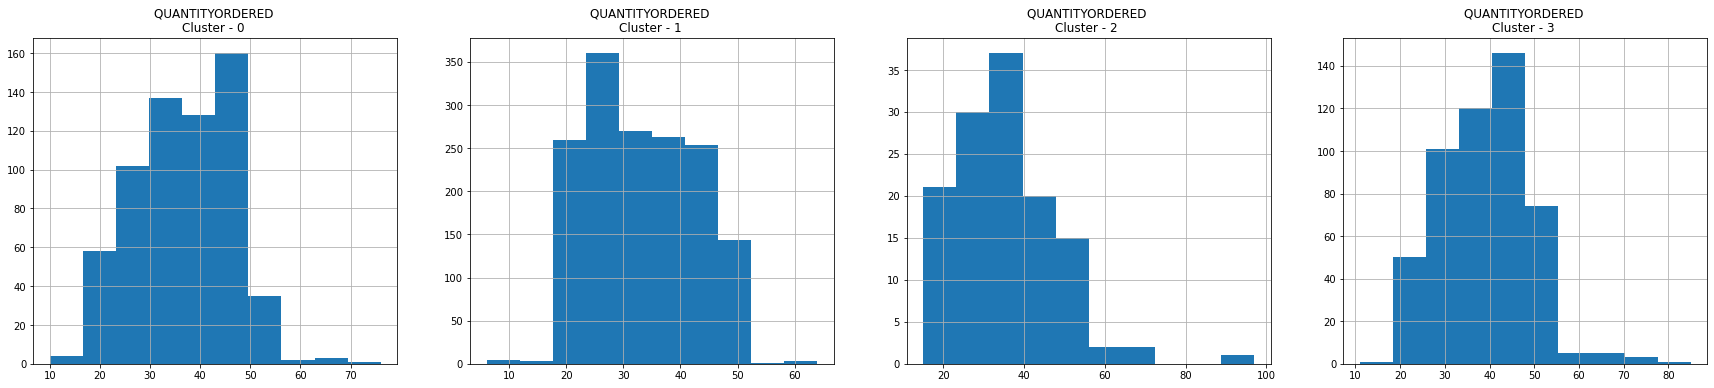

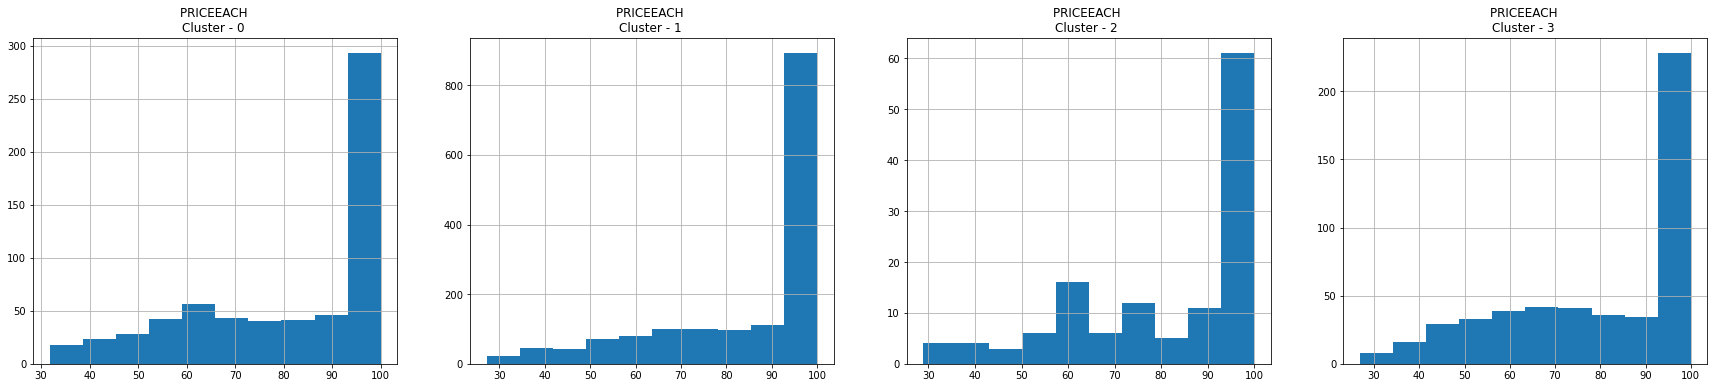

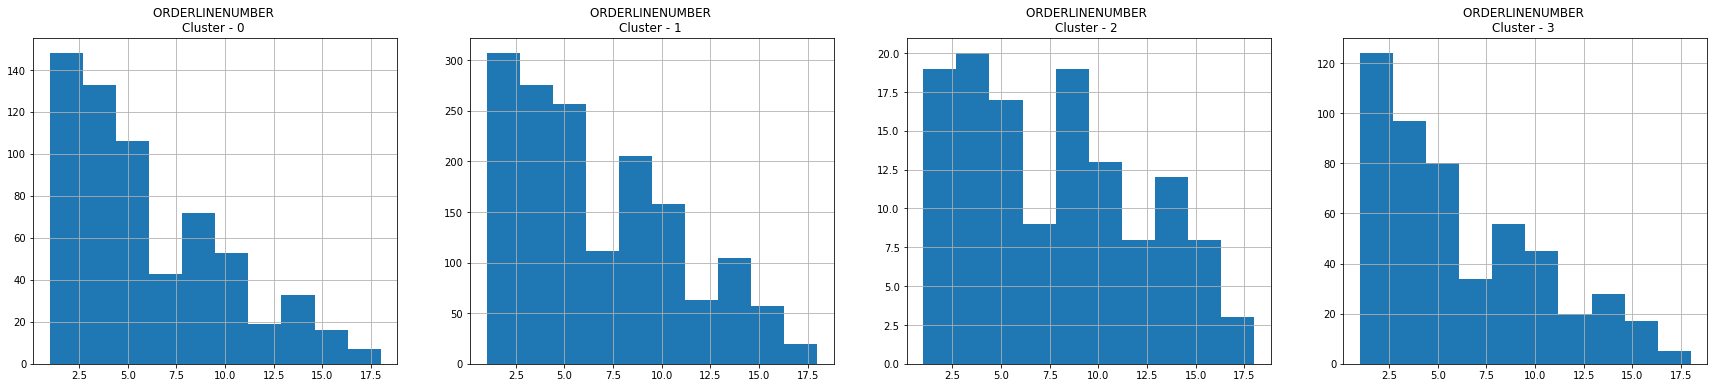

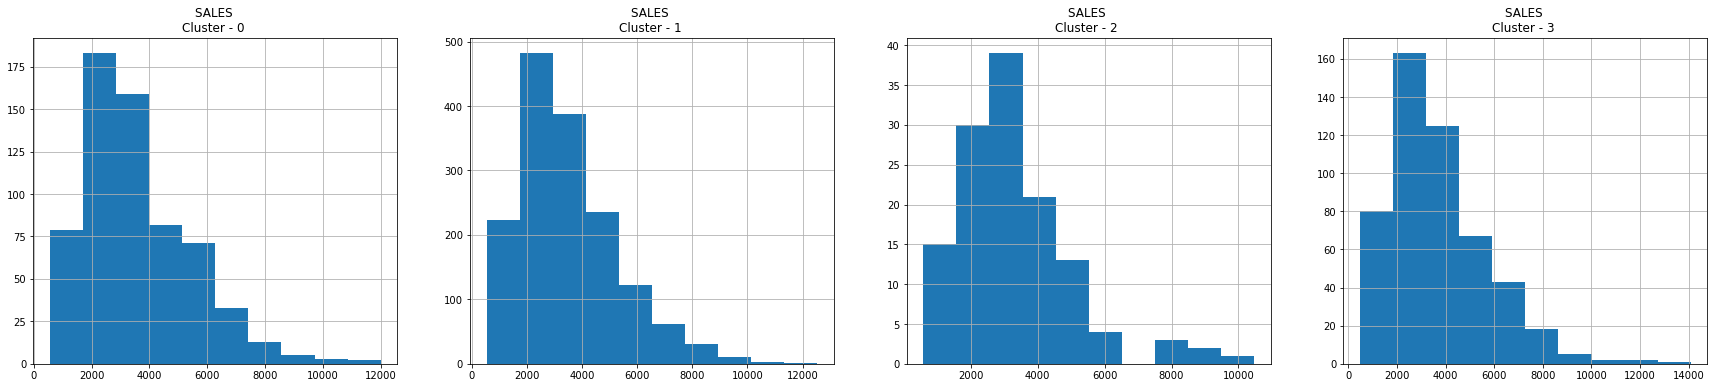

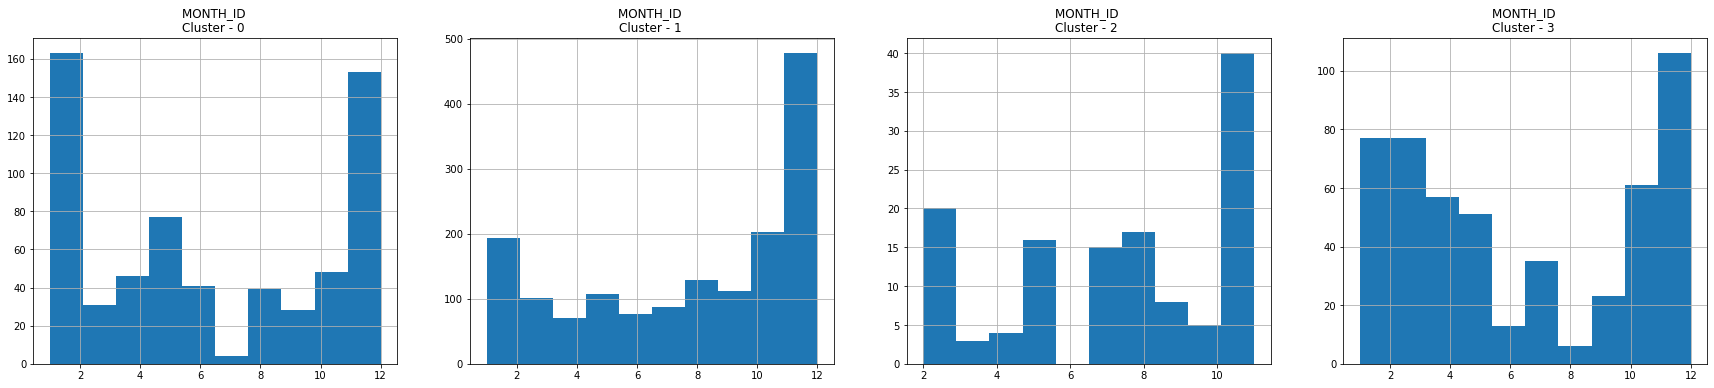

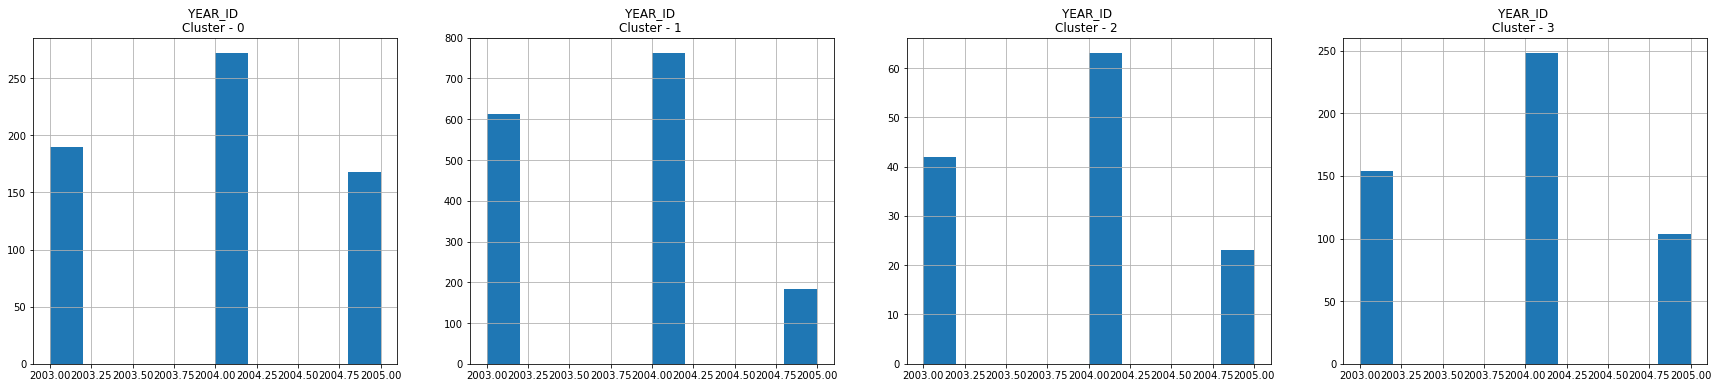

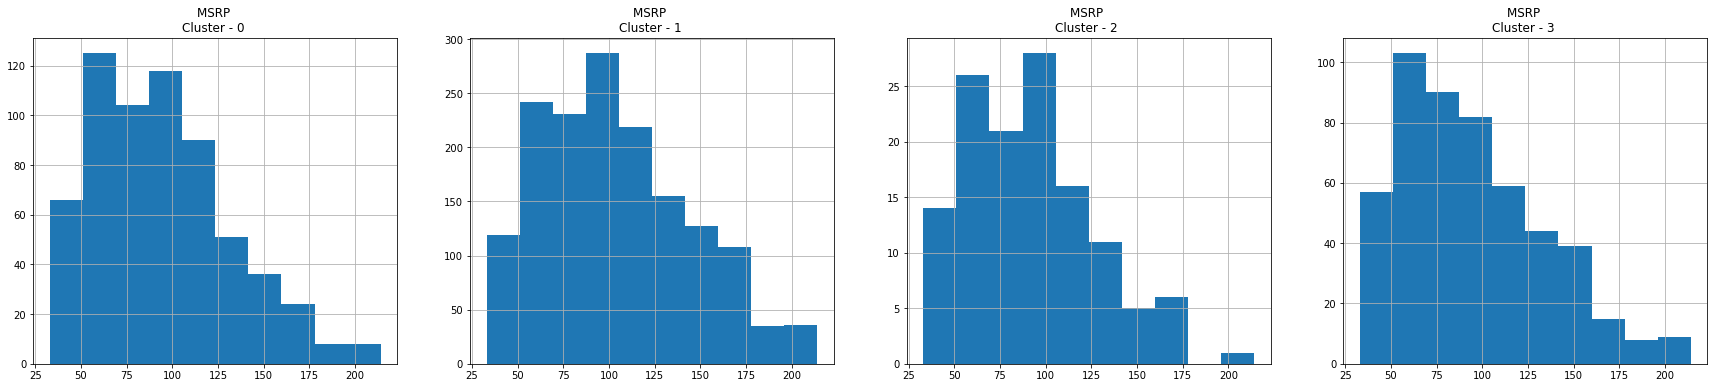

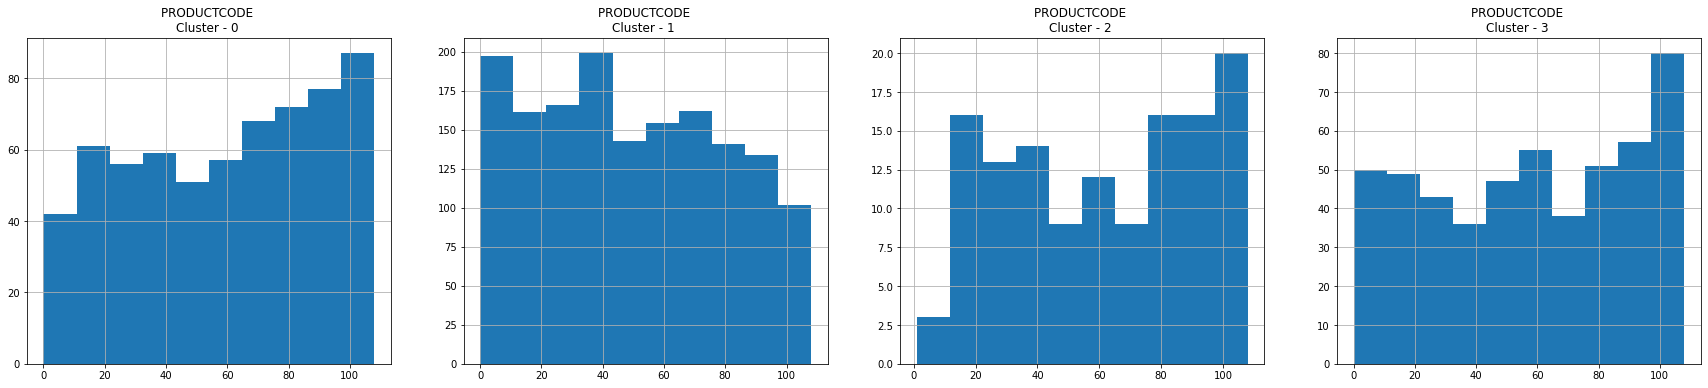

In [72]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
    plt.figure(figsize = (30, 6))
    for j in range(4):
        plt.subplot(1, 4, j+1)
        cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
        cluster[i].hist()
        plt.title('{} \nCluster - {} '.format(i,j))
plt.show()

In [193]:
scaler = StandardScaler()
cluster_df_scaled = scaler.fit_transform(cluster_centers)
columns = ['QUANTITY', 'PRICE', 'LINENUMBER',
       'SALES','MONTH','YEAR', 'MSRP']

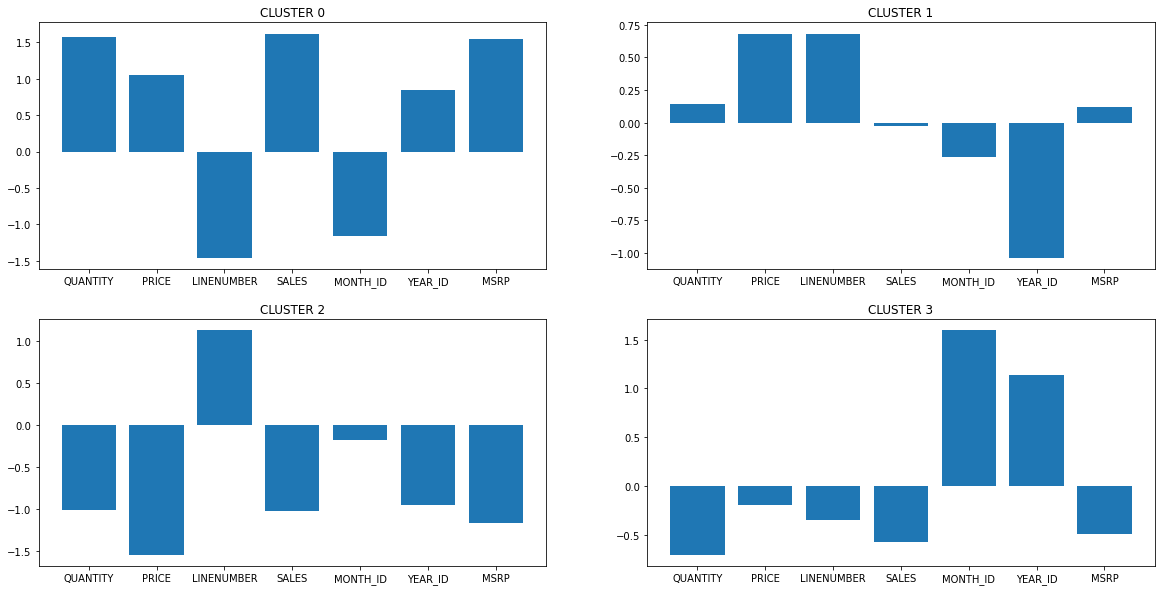

In [192]:
x = [1,2,3]
plt.figure(figsize = (20, 10))
for cluster in range(4):
    plt.subplot(2, 2, cluster+1)
    plt.bar(columns, cluster_df_scaled[cluster][:7])
    plt.title(f'CLUSTER {cluster}')
plt.show()